# Load libraries and set parameters

In [38]:
import torch
from torch import nn
import torch.nn.functional as F

import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
from torchinfo import summary

import torchvision
from torch import optim, nn
import timeit



RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

# Expansion of the MLP 
EXPANSION = 128



random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cuda" if torch.cuda.is_available() else "cpu"



# Patch Embedding class

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            # We use conv instead of linear for efficiency
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                # if kernel_size = stride -> no overlap
                kernel_size=patch_size,
                stride=patch_size
            ),
            # Linear projection of Flattened Patches. We keep the batch and we channels (b,c,h,w)
            nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Create a copy of the cls token for each of the elements of the BATCH
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        # Unify the position with the patches
        x = torch.cat([cls_token, x], dim=1)
        # Patch + Position Embedding
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)


In [11]:
patch1=nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=4).to(device)(x)
patch1.shape

torch.Size([512, 16, 7, 7])

In [12]:
patch2=nn.Flatten(2)(patch1)
patch2.shape

torch.Size([512, 16, 49])

In [13]:
patch3=patch2.permute(0,2,1)
patch3.shape

torch.Size([512, 49, 16])

In [14]:
cls_token1 = nn.Parameter(torch.randn(size=(1, 1, 16)))
cls_token1.shape

torch.Size([1, 1, 16])

In [15]:
cls_token2 = cls_token1.expand(512, -1, -1)
cls_token2.shape
# The same value repeated

torch.Size([512, 1, 16])

In [16]:
patch4 = torch.cat([cls_token2.to(device), patch3.to(device)], dim=1)
patch4.shape

torch.Size([512, 50, 16])

In [17]:
pos_embedding = nn.Parameter(torch.randn(size=(1, 50, 16)))
pos_embedding.shape

torch.Size([1, 50, 16])

In [19]:
patch_and_pos_embedding = patch4.to(device) + pos_embedding.to(device)
patch_and_pos_embedding.shape

torch.Size([512, 50, 16])

# ViT using PyTorch functions

In [23]:
class ViT_PyTorch(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, dim_feedforward=int(embed_dim*expansion), activation="gelu", batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [24]:
model1 = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)

In [25]:

print("\nSummary of the model1 (using PyTorch functions):")
summary(model1, input_size=(1, 1, 28, 28))


Summary of the model1 (using PyTorch functions):


Layer (type:depth-idx)                        Output Shape              Param #
ViT_PyTorch                                   [1, 10]                   --
├─PatchEmbedding: 1-1                         [1, 50, 16]               816
│    └─Sequential: 2-1                        [1, 16, 49]               --
│    │    └─Conv2d: 3-1                       [1, 16, 7, 7]             272
│    │    └─Flatten: 3-2                      [1, 16, 49]               --
│    └─Dropout: 2-2                           [1, 50, 16]               --
├─TransformerEncoder: 1-2                     [1, 50, 16]               --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-3      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-4      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-5      [1, 50, 16]               68,752
│    │    └─TransformerEncoderLayer: 3-6      [1, 50, 16]               68,752
├─

# Load EMNIST dataset

In [26]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
val_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=val_test_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_test_transform)





Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11502056.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 339347.99it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2736234.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2228653.34it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [28]:
train_dataset = Subset(train_data, range(48000))
val_dataset = Subset(val_data, range(48000, len(val_data)))

In [29]:
num_workers = torch.cuda.device_count() * 4
num_workers

4

In [30]:
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                        num_workers=num_workers, pin_memory=False,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

In [31]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    #print("x.shape: ", x.shape)
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    #print("x.shape: ", x.shape)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    #print("x.shape: ", x.shape)
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    #print("x.shape: ", x.shape)
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

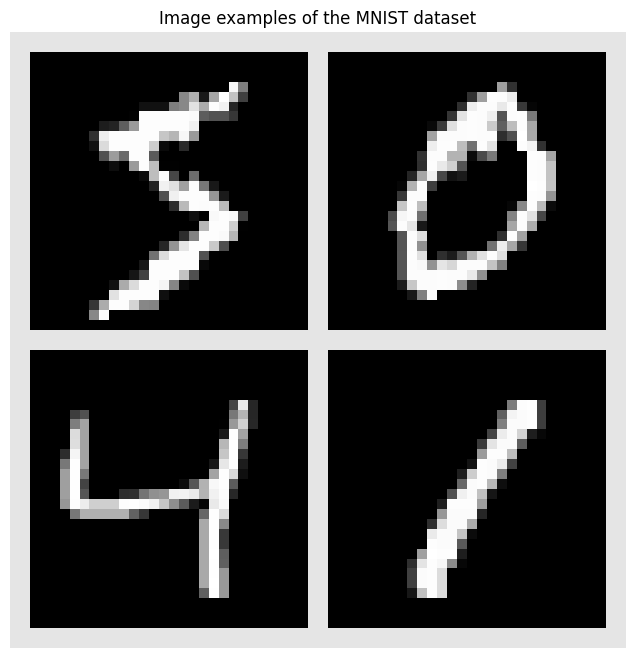

In [32]:
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([train_dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


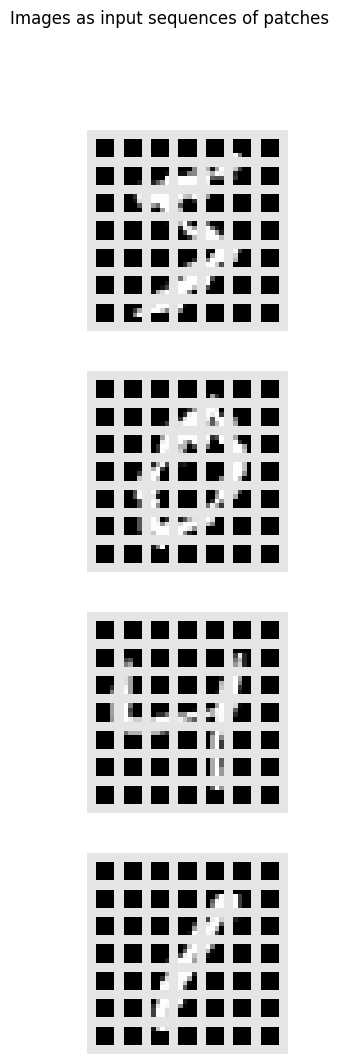

In [33]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=PATCH_SIZE, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(IMG_SIZE/PATCH_SIZE), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

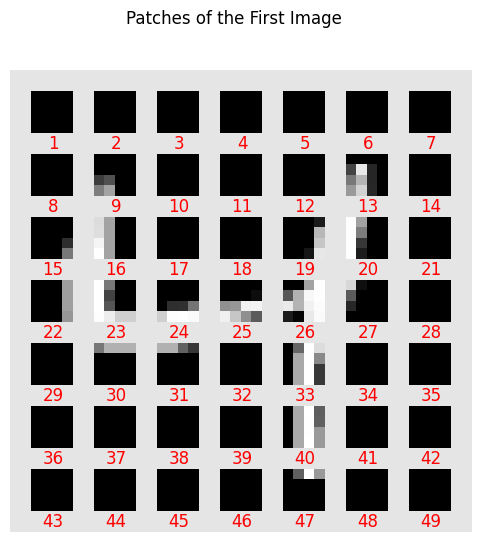

In [34]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=PATCH_SIZE, flatten_channels=False)

# Create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("Patches of the First Image")

# Plot the patches of the first image
img_grid = torchvision.utils.make_grid(img_patches[2], nrow=int(IMG_SIZE/PATCH_SIZE), normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
ax.imshow(img_grid)

# Annotate numbers from 1 to n in the top-center position of each patch
n = len(img_patches[0])
for i in range(n):
    patch_center_x = (i % (IMG_SIZE // PATCH_SIZE) + 0.6) * PATCH_SIZE*1.5
    patch_center_y = (i // (IMG_SIZE // PATCH_SIZE) + 1.095) * PATCH_SIZE*1.5
    ax.text(patch_center_x, patch_center_y, str(i+1), fontsize=12, color='red', ha='center', va='center')

ax.axis("off")
plt.show()
plt.close()


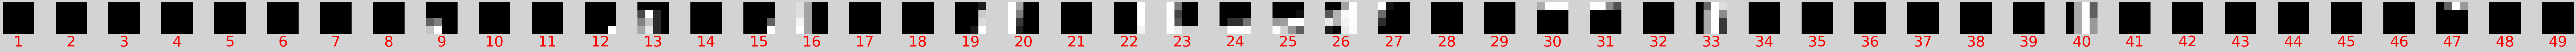

In [35]:
import matplotlib.pyplot as plt
import torchvision

# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=PATCH_SIZE, flatten_channels=False)

# Plot patches of the third image only
num_patches = img_patches[2].shape[0]
num_cols = num_patches
fig, ax = plt.subplots(nrows=1, ncols=num_cols, figsize=(num_cols * 2, 2), facecolor='lightgray')  # Cambio del color de fondo a gris

for i in range(num_patches):
    ax[i].imshow(img_patches[2][i].permute(1, 2, 0), cmap='gray')
    ax[i].axis("off")
    ax[i].text(0.5, -0.4, str(i+1), fontsize=40, color='red', ha='center', transform=ax[i].transAxes)

plt.tight_layout()
plt.savefig("eyy2.png")  # Guarda el gráfico en un archivo
plt.show()
plt.close()


# Training

In [36]:
model1 = ViT_PyTorch(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS, NUM_HEADS, NUM_ENCODERS, EXPANSION, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)


In [39]:
print("Showing the first 30 elements of each epoch!")
# Save losses and accuracies for plot
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model1.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, (data, target) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = data.float().to(device)
        label = target.type(torch.uint8).to(device)
        optimizer.zero_grad()
        y_pred = model1(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        loss = criterion(y_pred, label)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (idx + 1)
    
    # Saving metrics of training
    train_accuracy = sum(1 for x,y in zip(train_preds, train_labels) if x==y) / len(train_labels)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    

    model1.eval()
    
    # Validation
    
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = data.float().to(device)
            label = target.type(torch.uint8).to(device)
            y_pred = model1(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

    val_loss = val_running_loss / (idx + 1)
    
    # Saving metrics of validation
    val_accuracy = sum(1 for x,y in zip(val_preds, val_labels) if x==y) / len(val_labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Showing labels while training
    train_labels_array =  np.array([y.detach().numpy() for y in train_labels])
    train_preds_array = np.array([y.detach().numpy() for y in train_preds])
    val_labels_array =  np.array([y.detach().numpy() for y in val_labels])
    val_preds_array = np.array([y.detach().numpy() for y in val_preds])
    print("*" * 30)
    print(f"EPOCH {epoch+1}")
    print("Training predictions:   ", train_preds_array[:30])
    print("Training labels:        ", train_labels_array[:30])
    print("Validation predictions: ", val_preds_array[:30])
    print("Validation labels:      ", val_labels_array[:30])
    print("-" * 30)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Accuracy: {val_accuracy:.4f}")
    print("*" * 30)

     
stop= timeit.default_timer()
print(f"Training Time: {stop-start:.2f} s")

Showing the first 30 elements of each epoch!


  2%|▎         | 1/40 [00:10<06:42, 10.31s/it]

******************************
EPOCH 1
Training predictions:    [3 9 9 1 9 4 2 9 6 0 7 1 0 1 9 0 9 7 3 2 2 2 3 5 3 1 5 3 0 8]
Training labels:         [3 4 5 7 9 4 2 6 0 0 7 8 0 1 4 5 7 2 8 2 8 2 3 5 3 1 8 4 0 3]
Validation predictions:  [3 3 8 1 1 8 1 8 4 9 7 1 3 3 9 3 3 3 4 1 5 7 7 4 7 3 9 8 5 3]
Validation labels:       [2 3 8 1 1 8 1 6 4 9 7 1 8 1 9 8 5 3 4 1 4 7 9 4 7 5 7 0 0 2]
------------------------------
Train Loss: 1.3672
Valid Loss: 1.2171
Train Accuracy: 0.5984
Valid Accuracy: 0.6721
******************************


  5%|▌         | 2/40 [00:20<06:24, 10.11s/it]

******************************
EPOCH 2
Training predictions:    [3 5 0 4 4 9 0 2 0 7 9 3 1 3 8 6 0 4 3 1 9 3 7 9 5 7 4 3 0 6]
Training labels:         [3 5 0 4 4 9 0 7 5 7 9 3 2 0 8 6 4 4 3 1 9 8 7 9 7 7 4 8 6 6]
Validation predictions:  [1 4 1 1 2 3 2 1 1 4 8 5 4 2 2 6 2 0 8 5 4 6 9 7 5 3 4 0 3 7]
Validation labels:       [1 6 1 1 2 8 2 1 1 4 8 0 4 2 2 6 2 0 0 5 4 6 9 7 8 3 4 0 3 7]
------------------------------
Train Loss: 1.1959
Valid Loss: 1.0541
Train Accuracy: 0.6814
Valid Accuracy: 0.7500
******************************


  8%|▊         | 3/40 [00:30<06:11, 10.05s/it]

******************************
EPOCH 3
Training predictions:    [3 3 7 3 9 5 1 1 7 2 0 9 9 0 1 4 7 7 8 2 3 1 1 1 1 7 7 5 4 3]
Training labels:         [3 3 5 3 9 5 1 1 7 2 6 9 9 0 7 4 7 9 8 2 3 1 9 1 1 7 7 5 4 5]
Validation predictions:  [8 6 9 0 1 0 0 2 7 8 9 9 3 3 1 4 6 9 6 5 3 2 7 6 7 6 3 2 2 9]
Validation labels:       [8 6 9 6 1 0 0 2 7 8 5 9 3 8 1 4 6 9 6 9 3 2 7 6 7 6 2 5 2 9]
------------------------------
Train Loss: 1.0622
Valid Loss: 0.8858
Train Accuracy: 0.7313
Valid Accuracy: 0.8028
******************************


 10%|█         | 4/40 [00:40<06:05, 10.16s/it]

******************************
EPOCH 4
Training predictions:    [7 1 5 9 6 2 0 7 2 7 3 0 0 2 0 5 0 0 1 1 1 0 6 8 0 7 9 9 9 4]
Training labels:         [7 1 5 9 2 2 0 9 2 7 3 0 0 2 0 8 0 0 1 1 1 0 6 7 0 7 7 9 4 9]
Validation predictions:  [0 7 7 6 0 4 7 2 9 1 7 4 0 4 2 9 0 8 0 5 2 6 3 1 8 6 1 9 0 1]
Validation labels:       [0 5 2 6 0 2 7 2 9 1 7 4 0 4 2 9 0 0 0 5 2 3 3 9 8 6 1 4 0 1]
------------------------------
Train Loss: 0.9510
Valid Loss: 0.7856
Train Accuracy: 0.7682
Valid Accuracy: 0.8395
******************************


 12%|█▎        | 5/40 [00:50<05:52, 10.07s/it]

******************************
EPOCH 5
Training predictions:    [7 7 8 0 5 4 3 1 5 1 0 2 3 7 9 0 7 7 6 0 4 2 0 4 6 3 9 0 4 0]
Training labels:         [2 7 8 0 5 4 5 1 5 1 5 2 2 7 9 0 7 9 6 0 7 2 0 4 6 3 7 0 4 0]
Validation predictions:  [6 9 2 8 9 6 2 7 1 0 2 2 1 6 6 9 2 3 1 2 4 2 0 3 6 1 5 1 1 9]
Validation labels:       [6 7 2 8 9 6 2 7 1 0 2 2 1 0 6 9 2 3 1 2 4 2 0 3 6 1 5 1 2 9]
------------------------------
Train Loss: 0.8496
Valid Loss: 0.7317
Train Accuracy: 0.7991
Valid Accuracy: 0.8448
******************************


 15%|█▌        | 6/40 [01:00<05:39,  9.99s/it]

******************************
EPOCH 6
Training predictions:    [0 6 2 1 6 4 7 3 3 5 8 9 9 7 8 4 2 1 3 8 0 8 7 9 3 1 2 6 2 7]
Training labels:         [0 6 8 1 2 4 7 3 3 8 3 9 9 7 8 4 5 1 3 8 0 8 7 9 3 1 2 6 2 7]
Validation predictions:  [0 4 2 2 5 8 1 7 7 0 4 2 8 6 4 5 6 9 0 9 7 2 6 8 0 9 4 5 1 5]
Validation labels:       [0 4 2 2 5 8 1 7 7 0 9 2 8 2 4 5 6 9 0 9 7 2 6 8 0 7 4 1 1 5]
------------------------------
Train Loss: 0.7752
Valid Loss: 0.6442
Train Accuracy: 0.8173
Valid Accuracy: 0.8702
******************************


 18%|█▊        | 7/40 [01:10<05:32, 10.06s/it]

******************************
EPOCH 7
Training predictions:    [0 6 0 5 3 2 0 8 4 3 5 1 4 6 7 4 8 0 1 7 6 3 1 1 8 9 0 4 6 3]
Training labels:         [0 6 0 5 3 2 0 2 4 3 5 1 4 5 7 4 8 0 1 7 6 3 1 1 2 4 0 9 6 3]
Validation predictions:  [8 1 3 7 6 3 8 9 6 0 1 9 3 8 9 4 8 1 3 0 6 5 0 0 0 5 9 0 6 6]
Validation labels:       [8 1 3 7 6 3 1 7 6 0 1 9 3 8 2 4 8 1 3 0 6 5 0 0 6 5 8 9 2 6]
------------------------------
Train Loss: 0.7110
Valid Loss: 0.6142
Train Accuracy: 0.8354
Valid Accuracy: 0.8663
******************************


 20%|██        | 8/40 [01:20<05:20, 10.02s/it]

******************************
EPOCH 8
Training predictions:    [1 9 4 2 5 9 8 3 3 8 3 1 3 8 2 6 5 1 2 5 3 9 0 2 6 2 7 1 6 2]
Training labels:         [1 8 9 2 5 9 8 3 3 8 2 1 3 8 2 6 5 4 2 1 3 9 0 2 5 2 8 8 6 2]
Validation predictions:  [1 9 7 6 3 4 6 7 0 9 2 3 5 2 3 8 3 5 9 6 1 2 7 7 6 7 7 6 8 2]
Validation labels:       [1 9 7 6 3 4 6 7 0 9 2 3 5 2 3 8 3 5 9 6 1 2 7 7 6 7 7 6 8 2]
------------------------------
Train Loss: 0.6641
Valid Loss: 0.5736
Train Accuracy: 0.8407
Valid Accuracy: 0.8752
******************************


 22%|██▎       | 9/40 [01:30<05:10, 10.02s/it]

******************************
EPOCH 9
Training predictions:    [7 0 0 1 4 6 0 9 9 1 5 9 1 2 0 3 1 0 9 3 4 5 5 6 2 1 2 1 1 2]
Training labels:         [9 0 0 1 4 6 0 9 7 1 5 9 1 2 0 8 1 0 9 3 4 5 5 6 2 1 0 1 1 6]
Validation predictions:  [5 8 9 7 2 4 0 9 1 8 3 7 3 0 8 6 8 9 7 9 3 9 2 8 7 8 7 7 9 6]
Validation labels:       [5 8 9 7 2 4 0 9 1 2 3 7 3 0 0 6 8 9 7 9 3 8 2 8 7 8 7 7 9 6]
------------------------------
Train Loss: 0.6113
Valid Loss: 0.5066
Train Accuracy: 0.8541
Valid Accuracy: 0.8889
******************************


 25%|██▌       | 10/40 [01:40<05:02, 10.09s/it]

******************************
EPOCH 10
Training predictions:    [8 2 6 1 0 2 8 0 0 0 3 0 4 9 4 8 0 1 1 1 7 2 7 4 7 4 3 7 0 8]
Training labels:         [5 2 6 1 0 2 8 2 0 0 3 0 4 4 4 8 0 1 2 6 7 2 1 4 7 4 8 2 0 8]
Validation predictions:  [6 1 3 1 6 2 4 3 7 7 2 5 8 0 9 2 8 1 1 7 5 9 6 6 6 7 9 7 7 7]
Validation labels:       [6 1 3 1 6 7 4 3 7 7 2 5 8 0 9 2 8 1 1 7 5 9 0 6 6 7 9 7 7 7]
------------------------------
Train Loss: 0.5730
Valid Loss: 0.4756
Train Accuracy: 0.8622
Valid Accuracy: 0.8978
******************************


 28%|██▊       | 11/40 [01:51<04:54, 10.15s/it]

******************************
EPOCH 11
Training predictions:    [5 8 5 5 5 1 0 0 4 2 1 3 1 2 5 5 1 3 3 3 8 9 5 7 8 0 3 5 4 5]
Training labels:         [5 3 5 5 5 1 0 0 4 2 6 3 1 2 5 8 1 3 3 3 8 9 5 7 4 0 3 5 4 3]
Validation predictions:  [6 8 5 6 1 3 4 0 8 4 2 8 2 8 2 1 3 8 7 7 5 3 0 3 5 1 4 8 5 7]
Validation labels:       [6 8 6 6 1 3 4 0 8 4 2 8 2 8 2 1 3 8 7 7 5 3 5 3 5 1 4 8 5 7]
------------------------------
Train Loss: 0.5443
Valid Loss: 0.4544
Train Accuracy: 0.8660
Valid Accuracy: 0.8973
******************************


 30%|███       | 12/40 [02:01<04:43, 10.13s/it]

******************************
EPOCH 12
Training predictions:    [1 8 5 8 2 9 1 0 7 1 2 6 7 7 6 1 0 6 6 9 4 9 9 4 0 0 9 4 9 0]
Training labels:         [1 8 5 8 2 9 1 5 7 1 2 6 7 7 6 1 3 6 6 9 4 9 9 4 0 0 9 4 7 0]
Validation predictions:  [9 8 2 5 3 3 9 9 4 2 9 6 6 0 9 0 1 7 6 9 5 3 1 6 7 6 0 2 3 5]
Validation labels:       [9 8 2 5 3 3 9 9 4 2 9 6 6 0 9 0 1 7 6 9 8 3 1 6 7 6 0 2 3 5]
------------------------------
Train Loss: 0.5194
Valid Loss: 0.4315
Train Accuracy: 0.8703
Valid Accuracy: 0.9000
******************************


 32%|███▎      | 13/40 [02:11<04:33, 10.13s/it]

******************************
EPOCH 13
Training predictions:    [2 1 5 2 3 6 1 0 1 8 5 7 5 1 2 0 3 0 9 7 3 4 5 9 8 0 5 1 6 0]
Training labels:         [2 1 5 2 3 6 1 0 1 8 5 7 5 1 2 0 5 0 4 7 8 4 3 9 8 0 5 1 6 0]
Validation predictions:  [4 6 2 8 9 2 0 4 2 0 7 8 9 3 5 9 7 3 7 2 3 4 3 3 0 3 5 8 6 9]
Validation labels:       [2 6 2 8 9 2 0 4 2 0 7 8 9 3 5 9 7 3 7 2 5 4 3 3 0 3 5 8 6 9]
------------------------------
Train Loss: 0.4848
Valid Loss: 0.3937
Train Accuracy: 0.8780
Valid Accuracy: 0.9086
******************************


 35%|███▌      | 14/40 [02:21<04:26, 10.23s/it]

******************************
EPOCH 14
Training predictions:    [3 3 5 0 1 1 1 1 6 9 0 1 6 7 6 2 4 0 3 3 8 3 2 4 4 4 1 3 5 5]
Training labels:         [5 3 5 9 1 1 1 1 6 9 0 1 6 7 6 2 4 0 3 3 8 3 2 4 6 4 1 3 3 5]
Validation predictions:  [3 9 5 4 8 9 6 4 9 6 3 2 4 5 7 3 0 7 2 2 4 4 1 4 4 6 9 1 6 1]
Validation labels:       [3 9 5 4 8 9 6 4 9 6 3 2 4 5 7 3 3 7 2 3 4 4 1 4 9 6 9 1 6 1]
------------------------------
Train Loss: 0.4563
Valid Loss: 0.3796
Train Accuracy: 0.8851
Valid Accuracy: 0.9110
******************************


 38%|███▊      | 15/40 [02:31<04:15, 10.22s/it]

******************************
EPOCH 15
Training predictions:    [5 3 0 8 0 0 4 0 6 8 9 9 3 6 4 8 3 3 5 2 7 7 2 3 4 0 2 9 2 0]
Training labels:         [5 3 0 8 0 0 4 0 6 9 9 9 3 5 5 8 3 3 5 8 7 7 2 3 4 0 2 4 2 0]
Validation predictions:  [8 5 0 4 3 8 0 4 9 1 7 9 8 8 6 8 8 6 4 6 8 9 2 3 0 7 1 6 3 5]
Validation labels:       [8 5 0 4 3 8 0 4 9 1 7 9 8 8 6 8 8 6 4 6 8 8 2 3 0 7 1 1 3 5]
------------------------------
Train Loss: 0.4294
Valid Loss: 0.3486
Train Accuracy: 0.8914
Valid Accuracy: 0.9180
******************************


 40%|████      | 16/40 [02:42<04:04, 10.20s/it]

******************************
EPOCH 16
Training predictions:    [7 5 2 6 7 8 6 6 6 4 3 0 6 7 4 0 3 2 6 4 8 2 5 6 7 6 2 1 3 2]
Training labels:         [7 5 2 6 7 8 6 6 6 4 3 0 6 7 4 0 3 2 6 9 8 2 5 6 7 2 1 1 3 7]
Validation predictions:  [6 0 2 1 6 3 2 6 6 8 8 7 8 7 8 5 9 5 2 9 5 8 7 4 6 7 0 8 9 2]
Validation labels:       [6 0 2 1 6 3 2 6 5 8 8 7 8 7 8 5 9 5 2 4 5 8 7 4 6 7 0 8 9 2]
------------------------------
Train Loss: 0.4139
Valid Loss: 0.3315
Train Accuracy: 0.8926
Valid Accuracy: 0.9191
******************************


 42%|████▎     | 17/40 [02:52<03:57, 10.31s/it]

******************************
EPOCH 17
Training predictions:    [7 8 2 7 4 7 2 6 2 3 9 8 2 1 0 0 8 1 3 7 5 7 1 1 8 7 9 1 9 4]
Training labels:         [7 8 2 7 4 7 2 6 2 3 9 8 2 1 0 0 8 1 9 7 5 7 1 1 9 7 9 1 9 4]
Validation predictions:  [3 1 9 3 7 6 7 5 7 1 7 5 6 0 4 4 5 5 1 5 8 0 9 3 3 3 7 5 7 0]
Validation labels:       [3 1 9 3 7 0 7 5 9 1 7 5 6 0 4 4 5 5 1 5 8 0 9 8 3 3 7 5 7 0]
------------------------------
Train Loss: 0.3925
Valid Loss: 0.3100
Train Accuracy: 0.8977
Valid Accuracy: 0.9237
******************************


 45%|████▌     | 18/40 [03:02<03:44, 10.22s/it]

******************************
EPOCH 18
Training predictions:    [6 2 1 9 5 9 0 9 6 3 1 3 2 7 0 4 1 3 8 3 8 6 8 8 6 6 4 5 9 2]
Training labels:         [6 2 1 9 5 9 0 9 6 3 8 3 2 7 0 4 1 3 8 8 8 6 8 8 6 6 4 3 9 2]
Validation predictions:  [8 9 1 7 5 6 8 1 3 9 3 7 4 5 1 8 7 2 9 7 3 3 9 9 7 7 7 2 8 4]
Validation labels:       [8 9 1 7 5 6 8 1 3 9 3 7 4 5 1 8 7 7 9 9 3 3 9 9 7 7 7 2 8 4]
------------------------------
Train Loss: 0.3856
Valid Loss: 0.2933
Train Accuracy: 0.8981
Valid Accuracy: 0.9307
******************************


 48%|████▊     | 19/40 [03:12<03:34, 10.23s/it]

******************************
EPOCH 19
Training predictions:    [9 2 8 1 2 2 2 9 6 4 4 1 8 6 4 9 4 6 6 8 1 6 7 3 3 2 6 7 8 6]
Training labels:         [9 2 8 1 2 2 2 9 6 4 4 1 8 6 4 9 4 6 6 8 1 6 7 3 3 2 6 7 8 6]
Validation predictions:  [1 7 0 5 4 0 4 6 9 5 9 0 9 4 2 3 6 1 4 6 9 1 3 2 3 8 7 3 4 8]
Validation labels:       [1 7 0 5 4 0 4 6 9 5 9 0 9 4 2 3 6 1 4 6 9 1 3 2 8 8 7 3 4 8]
------------------------------
Train Loss: 0.3728
Valid Loss: 0.2961
Train Accuracy: 0.8997
Valid Accuracy: 0.9264
******************************


 50%|█████     | 20/40 [03:23<03:26, 10.31s/it]

******************************
EPOCH 20
Training predictions:    [1 4 9 7 3 0 6 9 0 6 9 5 7 4 1 0 4 9 1 7 3 9 1 4 9 9 4 6 2 6]
Training labels:         [1 4 9 7 2 2 6 9 0 6 9 8 7 9 1 0 4 9 1 7 3 9 1 4 9 9 4 6 2 6]
Validation predictions:  [2 5 0 1 1 0 7 0 5 4 1 2 6 9 0 3 6 9 5 4 9 7 0 3 8 5 2 4 5 6]
Validation labels:       [2 3 0 1 1 0 7 0 5 4 1 2 6 9 0 3 6 9 5 4 9 7 0 3 8 5 2 4 5 6]
------------------------------
Train Loss: 0.3562
Valid Loss: 0.2825
Train Accuracy: 0.9044
Valid Accuracy: 0.9278
******************************


 52%|█████▎    | 21/40 [03:33<03:16, 10.32s/it]

******************************
EPOCH 21
Training predictions:    [7 7 9 2 1 3 1 5 1 9 8 8 7 4 3 7 7 5 6 1 8 0 9 2 7 5 1 0 4 4]
Training labels:         [7 7 9 7 1 3 1 5 1 9 8 8 7 4 3 7 7 5 6 3 3 0 9 1 7 5 1 0 4 4]
Validation predictions:  [0 8 0 7 1 7 2 7 5 5 9 1 4 8 4 4 6 6 7 7 0 1 6 4 7 5 9 7 1 9]
Validation labels:       [0 8 0 7 1 4 2 7 5 5 8 1 4 8 4 4 6 6 7 7 0 1 6 4 7 5 9 7 1 9]
------------------------------
Train Loss: 0.3487
Valid Loss: 0.2763
Train Accuracy: 0.9044
Valid Accuracy: 0.9293
******************************


 55%|█████▌    | 22/40 [03:43<03:05, 10.29s/it]

******************************
EPOCH 22
Training predictions:    [9 7 5 6 8 5 3 1 2 0 6 6 0 9 6 6 2 8 3 0 6 3 8 1 6 1 8 1 1 6]
Training labels:         [9 7 5 6 8 5 3 1 2 0 6 4 0 9 6 6 3 8 3 0 6 3 8 1 6 1 2 1 1 6]
Validation predictions:  [7 0 3 1 1 4 3 4 9 5 7 5 5 8 0 1 6 5 4 4 8 6 2 6 0 5 2 9 5 0]
Validation labels:       [7 0 8 1 7 4 3 4 9 5 7 5 5 8 0 1 6 5 4 4 8 6 2 2 0 5 2 9 5 0]
------------------------------
Train Loss: 0.3345
Valid Loss: 0.2544
Train Accuracy: 0.9084
Valid Accuracy: 0.9343
******************************


 57%|█████▊    | 23/40 [03:54<02:55, 10.35s/it]

******************************
EPOCH 23
Training predictions:    [2 3 7 5 5 2 5 4 4 8 5 8 1 3 9 3 0 1 1 4 6 8 1 8 1 3 7 6 5 7]
Training labels:         [1 3 7 5 5 3 5 4 6 8 5 3 1 3 5 3 0 1 2 4 6 8 1 8 1 3 7 1 8 7]
Validation predictions:  [3 9 3 7 2 0 1 7 6 2 2 9 8 2 7 7 3 4 2 3 7 2 0 3 5 0 3 6 2 1]
Validation labels:       [8 9 3 7 2 0 1 7 6 2 2 9 8 2 7 7 5 4 2 3 7 2 0 3 5 0 3 6 2 1]
------------------------------
Train Loss: 0.3236
Valid Loss: 0.2565
Train Accuracy: 0.9123
Valid Accuracy: 0.9327
******************************


 60%|██████    | 24/40 [04:04<02:44, 10.28s/it]

******************************
EPOCH 24
Training predictions:    [6 6 9 4 1 4 9 3 2 1 8 7 4 4 3 4 4 2 3 0 9 8 5 7 2 4 6 7 6 2]
Training labels:         [6 6 9 4 1 4 9 3 2 1 8 9 4 2 1 4 4 2 3 0 9 8 5 7 2 4 6 7 6 2]
Validation predictions:  [8 6 2 2 9 8 1 5 6 3 4 5 7 1 1 6 0 0 9 0 2 3 7 2 7 4 0 8 2 6]
Validation labels:       [8 6 2 2 9 8 1 5 6 3 4 3 7 1 1 6 0 0 9 0 2 3 7 2 7 4 0 8 2 6]
------------------------------
Train Loss: 0.3133
Valid Loss: 0.2458
Train Accuracy: 0.9118
Valid Accuracy: 0.9366
******************************


 62%|██████▎   | 25/40 [04:14<02:33, 10.24s/it]

******************************
EPOCH 25
Training predictions:    [7 0 1 3 2 8 1 6 1 9 1 8 9 9 2 2 9 1 4 0 3 2 3 9 4 2 4 4 1 8]
Training labels:         [7 0 1 3 2 8 1 6 1 9 1 8 4 9 2 2 4 1 4 0 3 2 3 9 4 2 4 6 1 2]
Validation predictions:  [9 6 5 9 8 1 0 1 8 5 7 0 7 1 5 3 3 9 9 1 0 9 1 3 6 5 1 9 9 8]
Validation labels:       [9 6 5 9 8 1 0 1 8 5 7 0 7 5 5 3 3 9 9 1 0 9 1 3 6 5 1 9 9 8]
------------------------------
Train Loss: 0.3080
Valid Loss: 0.2435
Train Accuracy: 0.9143
Valid Accuracy: 0.9350
******************************


 65%|██████▌   | 26/40 [04:24<02:23, 10.24s/it]

******************************
EPOCH 26
Training predictions:    [4 1 8 5 4 5 6 5 9 8 4 9 9 8 4 4 4 7 4 8 1 7 0 0 1 8 9 4 4 0]
Training labels:         [4 1 8 5 4 5 6 5 9 8 4 9 9 8 2 4 4 7 4 8 1 7 0 0 1 8 9 4 9 0]
Validation predictions:  [9 9 9 2 3 1 1 2 7 0 6 0 3 7 2 6 8 6 6 9 2 6 3 6 5 1 7 5 3 7]
Validation labels:       [7 9 9 2 3 1 1 2 7 0 6 8 3 7 2 6 8 6 6 8 2 6 3 6 5 1 7 5 3 7]
------------------------------
Train Loss: 0.2972
Valid Loss: 0.2305
Train Accuracy: 0.9166
Valid Accuracy: 0.9407
******************************


 68%|██████▊   | 27/40 [04:34<02:12, 10.18s/it]

******************************
EPOCH 27
Training predictions:    [6 6 0 7 7 5 7 1 9 0 7 5 2 0 2 6 3 4 6 2 4 0 5 2 1 0 5 6 8 3]
Training labels:         [6 6 5 7 7 5 7 1 9 0 7 1 2 0 2 6 3 4 6 2 4 0 5 2 1 0 5 6 8 3]
Validation predictions:  [4 4 9 2 5 9 3 9 3 3 9 8 2 7 1 2 4 6 7 3 1 5 9 1 7 8 9 0 1 0]
Validation labels:       [4 4 9 2 5 9 3 9 3 3 9 8 2 7 1 2 4 6 7 3 1 5 4 1 7 8 9 0 1 0]
------------------------------
Train Loss: 0.2852
Valid Loss: 0.2148
Train Accuracy: 0.9193
Valid Accuracy: 0.9430
******************************


 70%|███████   | 28/40 [04:45<02:01, 10.16s/it]

******************************
EPOCH 28
Training predictions:    [4 5 0 3 2 7 7 9 3 1 0 9 1 7 9 3 3 0 3 2 8 7 2 8 2 5 6 9 1 3]
Training labels:         [4 5 0 3 2 7 7 9 3 9 0 1 1 2 9 3 3 0 3 2 8 7 2 8 2 6 6 9 1 3]
Validation predictions:  [2 4 8 5 2 7 9 0 6 9 3 5 6 7 6 1 6 9 3 9 3 0 3 9 1 8 7 9 9 3]
Validation labels:       [2 4 8 5 2 7 9 0 6 9 3 5 6 7 6 1 6 9 3 9 3 5 3 9 1 8 7 8 9 3]
------------------------------
Train Loss: 0.2841
Valid Loss: 0.2397
Train Accuracy: 0.9197
Valid Accuracy: 0.9319
******************************


 72%|███████▎  | 29/40 [04:55<01:52, 10.24s/it]

******************************
EPOCH 29
Training predictions:    [0 6 9 3 6 5 3 1 2 3 9 9 5 8 5 9 3 3 4 3 1 1 6 4 8 6 3 9 3 8]
Training labels:         [0 6 9 2 6 5 3 1 2 3 9 9 5 8 5 8 3 3 4 3 1 1 6 4 8 6 3 9 5 8]
Validation predictions:  [8 3 6 1 2 6 5 2 6 9 7 4 4 6 3 4 6 2 4 1 5 8 7 2 8 4 6 0 6 4]
Validation labels:       [8 3 6 1 2 6 5 2 6 9 7 4 4 6 3 4 6 7 4 1 5 8 7 2 8 4 6 0 5 4]
------------------------------
Train Loss: 0.2746
Valid Loss: 0.2081
Train Accuracy: 0.9221
Valid Accuracy: 0.9427
******************************


 75%|███████▌  | 30/40 [05:05<01:41, 10.18s/it]

******************************
EPOCH 30
Training predictions:    [5 7 3 9 9 2 2 2 8 7 9 7 3 9 8 3 5 1 6 2 0 9 9 0 0 6 4 9 0 4]
Training labels:         [5 7 3 4 9 2 5 7 8 7 9 7 3 9 7 3 3 1 6 8 0 3 9 0 0 6 4 9 0 4]
Validation predictions:  [3 6 0 0 4 9 3 4 5 9 9 0 7 9 1 8 7 9 9 3 0 5 6 1 1 2 1 5 0 6]
Validation labels:       [3 6 0 0 4 9 3 4 5 7 9 0 7 9 1 8 7 9 9 3 0 5 6 1 1 4 1 5 0 4]
------------------------------
Train Loss: 0.2660
Valid Loss: 0.1976
Train Accuracy: 0.9238
Valid Accuracy: 0.9477
******************************


 78%|███████▊  | 31/40 [05:15<01:31, 10.16s/it]

******************************
EPOCH 31
Training predictions:    [1 6 8 1 0 8 2 7 9 8 9 8 2 7 2 7 0 5 0 7 8 2 6 5 8 3 8 7 4 2]
Training labels:         [1 6 3 1 0 8 2 7 2 8 9 8 2 7 2 7 0 5 0 5 2 2 6 9 8 3 8 7 4 2]
Validation predictions:  [3 3 0 9 0 7 1 0 2 5 6 4 9 7 2 3 0 2 7 5 1 0 2 9 3 0 7 7 9 8]
Validation labels:       [3 3 0 9 0 7 1 0 2 5 6 4 4 7 3 3 0 2 7 5 1 0 2 9 3 0 7 7 9 8]
------------------------------
Train Loss: 0.2609
Valid Loss: 0.1982
Train Accuracy: 0.9237
Valid Accuracy: 0.9454
******************************


 80%|████████  | 32/40 [05:25<01:21, 10.14s/it]

******************************
EPOCH 32
Training predictions:    [6 4 4 5 0 4 1 8 9 4 4 9 5 3 8 3 9 0 8 0 4 7 8 4 9 3 4 6 7 4]
Training labels:         [6 4 4 5 0 4 1 8 9 4 9 9 5 3 8 3 1 0 8 0 4 7 8 4 9 3 4 6 7 7]
Validation predictions:  [8 3 2 0 0 6 0 6 0 1 6 1 8 2 5 8 8 5 2 4 7 0 4 2 7 6 8 4 7 1]
Validation labels:       [8 3 2 0 0 6 0 6 0 1 6 1 8 2 5 8 8 5 2 4 7 0 4 2 7 6 8 4 7 1]
------------------------------
Train Loss: 0.2554
Valid Loss: 0.1911
Train Accuracy: 0.9266
Valid Accuracy: 0.9472
******************************


 82%|████████▎ | 33/40 [05:35<01:10, 10.09s/it]

******************************
EPOCH 33
Training predictions:    [4 8 1 7 2 5 5 0 2 1 2 4 7 9 1 7 2 3 0 6 5 5 2 1 6 8 8 3 9 7]
Training labels:         [4 8 1 7 2 3 5 0 2 1 8 4 7 9 1 7 2 3 0 6 5 5 2 1 6 8 8 3 9 7]
Validation predictions:  [9 0 7 3 3 3 2 6 6 0 5 9 2 1 9 4 2 7 4 8 8 7 4 0 2 8 9 6 6 2]
Validation labels:       [5 0 7 3 2 3 2 6 6 0 5 9 2 1 9 4 2 7 4 8 8 7 4 0 2 8 9 6 6 2]
------------------------------
Train Loss: 0.2490
Valid Loss: 0.1869
Train Accuracy: 0.9275
Valid Accuracy: 0.9465
******************************


 85%|████████▌ | 34/40 [05:45<01:00, 10.07s/it]

******************************
EPOCH 34
Training predictions:    [5 6 7 5 6 7 9 4 0 2 6 8 6 7 7 0 9 5 2 6 5 4 4 8 7 6 4 9 1 9]
Training labels:         [5 6 7 5 6 7 7 4 0 2 6 8 6 7 7 0 9 5 2 6 5 4 9 8 7 6 4 9 1 9]
Validation predictions:  [2 1 9 0 0 2 9 6 6 1 5 2 1 2 2 7 8 4 9 1 3 0 8 0 7 0 9 2 3 4]
Validation labels:       [2 1 9 0 2 2 9 6 6 1 5 2 1 2 2 7 8 4 9 1 3 0 8 0 7 0 9 2 3 4]
------------------------------
Train Loss: 0.2483
Valid Loss: 0.1954
Train Accuracy: 0.9277
Valid Accuracy: 0.9457
******************************


 88%|████████▊ | 35/40 [05:55<00:50, 10.03s/it]

******************************
EPOCH 35
Training predictions:    [8 2 1 8 9 7 2 2 6 6 0 2 1 8 6 9 7 0 4 1 7 5 6 2 1 1 6 4 0 1]
Training labels:         [8 2 1 8 9 7 2 2 5 6 0 2 1 8 6 7 4 0 4 1 7 5 6 2 1 6 6 4 0 1]
Validation predictions:  [6 3 2 3 8 5 4 8 3 9 8 4 1 9 8 7 4 0 3 4 7 3 5 6 9 9 3 7 1 2]
Validation labels:       [6 3 2 3 8 5 4 8 3 9 8 4 1 9 8 7 4 0 3 4 7 3 5 6 9 9 3 7 1 2]
------------------------------
Train Loss: 0.2429
Valid Loss: 0.1870
Train Accuracy: 0.9287
Valid Accuracy: 0.9489
******************************


 90%|█████████ | 36/40 [06:06<00:40, 10.13s/it]

******************************
EPOCH 36
Training predictions:    [1 3 7 6 5 5 4 1 6 6 9 8 3 8 6 7 8 5 8 8 9 0 7 5 9 9 4 3 0 5]
Training labels:         [1 3 7 6 5 5 4 1 6 6 9 8 3 8 6 7 8 5 8 8 9 0 7 5 9 9 4 3 0 5]
Validation predictions:  [0 7 1 8 0 5 2 5 6 8 0 1 1 4 1 6 8 0 6 8 9 2 7 9 5 9 9 9 4 6]
Validation labels:       [0 7 1 8 0 3 2 5 6 8 0 1 1 4 1 6 8 0 6 8 9 2 7 9 5 9 9 9 4 6]
------------------------------
Train Loss: 0.2360
Valid Loss: 0.1735
Train Accuracy: 0.9301
Valid Accuracy: 0.9516
******************************


 92%|█████████▎| 37/40 [06:16<00:30, 10.12s/it]

******************************
EPOCH 37
Training predictions:    [6 2 3 8 7 8 3 5 8 9 6 1 7 8 1 6 1 2 5 7 1 1 6 8 1 2 8 2 0 9]
Training labels:         [6 2 3 8 7 8 3 5 9 9 6 1 8 8 1 6 1 2 3 7 1 1 6 9 1 2 8 2 2 9]
Validation predictions:  [9 3 3 4 5 2 6 3 5 1 9 7 6 5 2 3 3 6 0 7 8 9 3 8 4 2 7 9 3 4]
Validation labels:       [9 3 3 4 5 2 6 3 5 1 9 7 6 5 2 3 5 6 0 7 8 9 8 8 4 2 7 9 3 6]
------------------------------
Train Loss: 0.2326
Valid Loss: 0.1761
Train Accuracy: 0.9326
Valid Accuracy: 0.9503
******************************


 95%|█████████▌| 38/40 [06:26<00:20, 10.13s/it]

******************************
EPOCH 38
Training predictions:    [6 8 9 9 1 5 2 2 6 7 0 8 5 7 7 6 1 5 8 5 8 6 1 5 1 4 0 5 1 2]
Training labels:         [6 8 9 9 1 5 2 2 6 7 0 8 5 7 7 6 1 3 8 5 1 6 1 5 1 4 0 5 1 2]
Validation predictions:  [2 6 3 7 6 6 0 6 8 5 1 8 3 2 3 9 5 0 9 9 0 3 8 4 0 2 8 3 1 7]
Validation labels:       [2 6 3 7 2 6 0 6 8 5 1 8 3 2 3 9 5 0 9 9 0 3 8 4 0 2 8 2 1 7]
------------------------------
Train Loss: 0.2196
Valid Loss: 0.1753
Train Accuracy: 0.9350
Valid Accuracy: 0.9508
******************************


 98%|█████████▊| 39/40 [06:36<00:10, 10.28s/it]

******************************
EPOCH 39
Training predictions:    [5 3 7 8 9 0 5 0 6 7 0 5 9 4 2 5 8 8 3 8 9 6 5 6 4 5 8 9 1 4]
Training labels:         [5 3 7 5 9 0 5 0 8 7 0 5 9 4 2 5 8 8 3 8 9 6 3 6 4 5 8 3 1 4]
Validation predictions:  [6 7 6 9 2 0 6 3 7 0 1 3 1 4 0 0 7 7 3 0 4 2 3 5 0 1 9 2 7 3]
Validation labels:       [6 7 6 9 2 0 6 3 7 0 1 3 1 4 0 0 7 7 3 0 4 2 3 5 0 1 9 2 7 3]
------------------------------
Train Loss: 0.2207
Valid Loss: 0.1632
Train Accuracy: 0.9360
Valid Accuracy: 0.9553
******************************


100%|██████████| 40/40 [06:46<00:00, 10.17s/it]

******************************
EPOCH 40
Training predictions:    [9 8 2 2 2 9 0 2 7 9 5 0 3 6 9 3 5 6 5 8 8 0 5 0 9 8 5 2 9 3]
Training labels:         [9 8 2 2 2 9 0 2 7 9 5 0 3 6 9 3 5 6 8 7 8 0 5 0 9 8 5 2 9 3]
Validation predictions:  [3 2 8 9 9 2 2 7 0 9 5 8 3 0 1 0 8 5 4 1 7 0 4 6 0 9 8 5 5 2]
Validation labels:       [3 2 8 9 9 2 2 7 0 9 5 8 3 0 1 0 8 5 4 1 7 0 4 6 0 5 8 5 5 5]
------------------------------
Train Loss: 0.2137
Valid Loss: 0.1806
Train Accuracy: 0.9364
Valid Accuracy: 0.9487
******************************
Training Time: 406.90 s


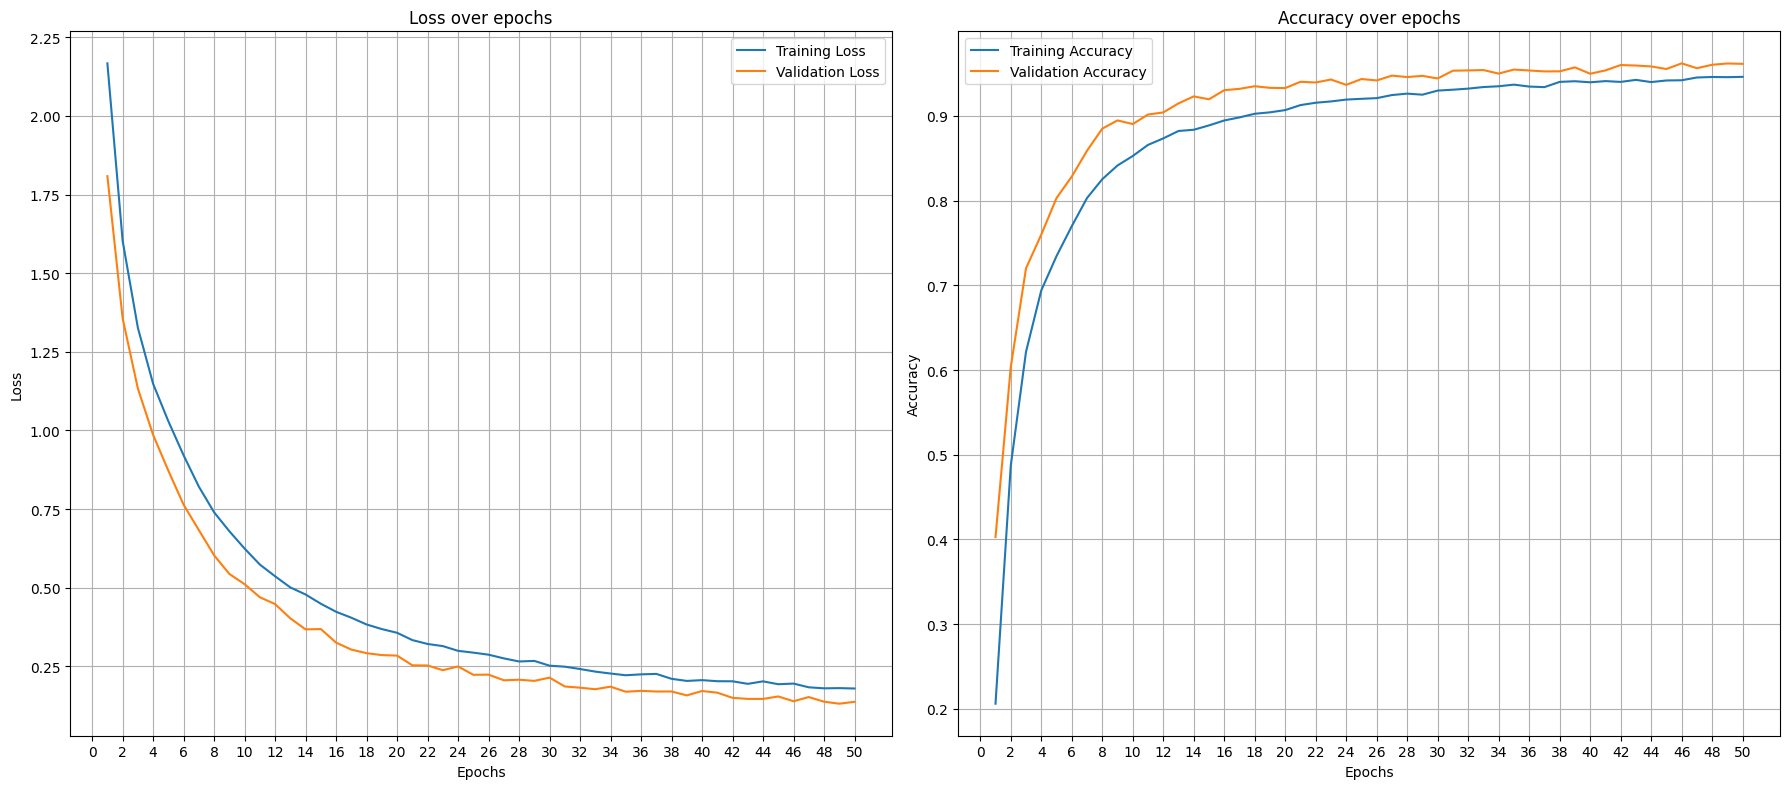

In [80]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 2))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 2)))  
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [81]:
test_labels = []
test_preds = []
test_running_loss = 0
with torch.no_grad():
    for idx, (data, target) in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = data.float().to(device)
        label = target.type(torch.uint8).to(device)
        y_pred = model1(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        test_labels.extend(label.cpu().detach())
        test_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)
        test_running_loss += loss.item()

test_loss = test_running_loss / (idx + 1)

test_accuracy = sum(1 for x,y in zip(test_preds, test_labels) if x==y) / len(test_labels)

print("-" * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("-" * 30)

100%|██████████| 20/20 [00:01<00:00, 16.54it/s]

------------------------------
Test Loss: 0.1356
Test Accuracy: 0.9608
------------------------------
